# Salesforce 6/18 Data Clean

## Part 1
- Standardize U.S. naming "United States"
- If a contact has something in state, can fill the blank with U.S.
- Export a list of everything to be updated

## Part 2 
- Identify missing emails (should be none)
- Fill missing email from Dakota if relevant
- Review duplicates
- Clean and consolidate dupes (export into a different file or sheet)

In [1]:
%pip install pandas openpyxl matplotlib 
import pandas as pd
import matplotlib.pyplot as plt
import os
import difflib
from openpyxl import load_workbook



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
print(os.getcwd())

dakota_file_path =  "../../data/all_contacts/Dakota_All_Contacts.xlsx"
dakota_df=pd.read_excel(dakota_file_path)

salesforce_file_path=file_path = "../../data/all_contacts/\Contact_SF_Extract_6_16_25.xlsx"
salesforce_df = pd.read_excel(salesforce_file_path, sheet_name='Contacts')

dakota_df.head()
salesforce_df.head()

print(f"Total number of account entries: {dakota_df['Account Name'].count()}")

<>:6: SyntaxWarning: invalid escape sequence '\C'
<>:6: SyntaxWarning: invalid escape sequence '\C'
C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_13932\1658930439.py:6: SyntaxWarning: invalid escape sequence '\C'
  salesforce_file_path=file_path = "../../data/all_contacts/\Contact_SF_Extract_6_16_25.xlsx"


c:\Users\MarkBogorad\OneDrive - Rockefeller Capital Management\MarkB\RCM\Mark\data_cleaning
Total number of account entries: 167025


# United States Standardization

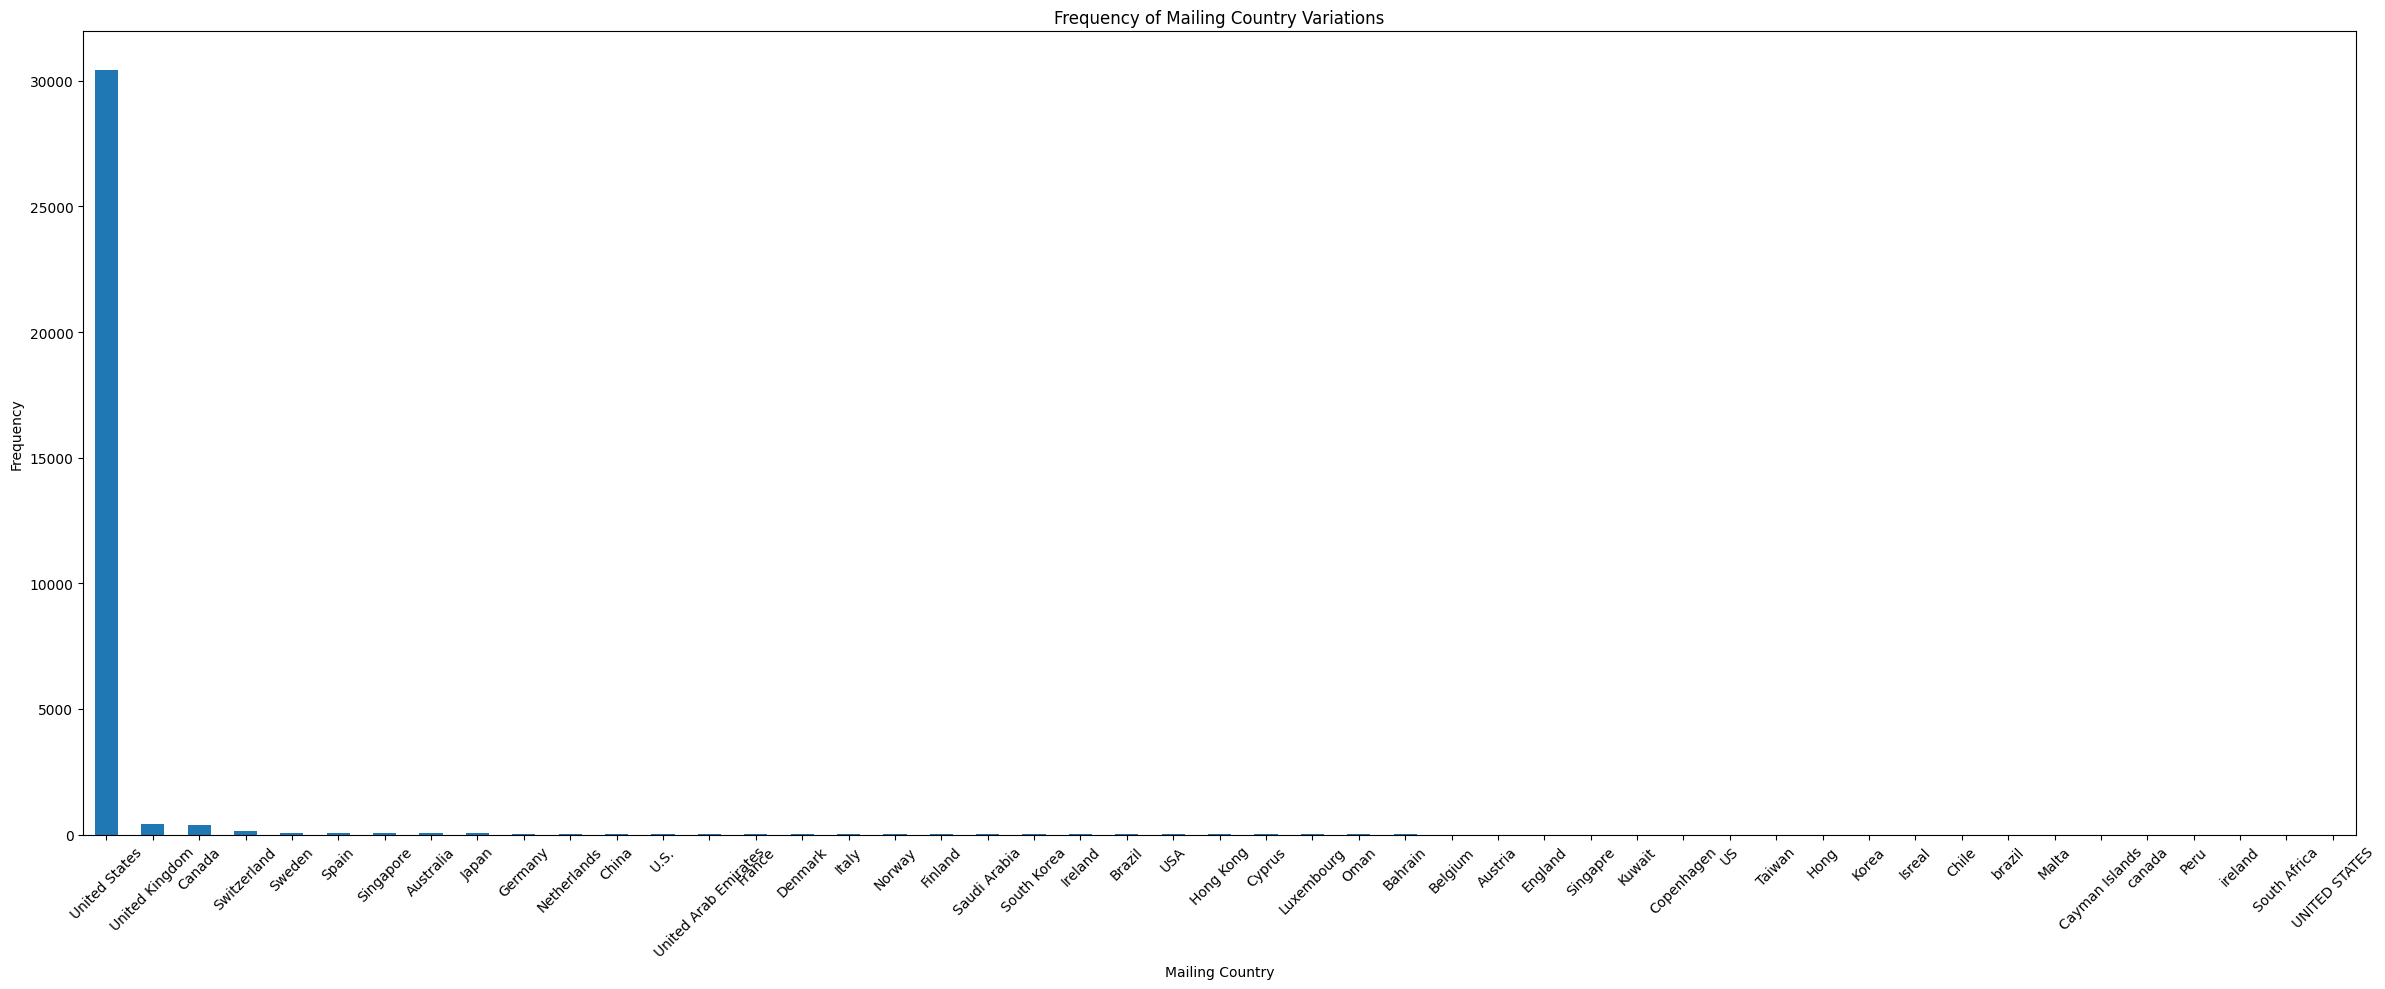

In [3]:
# Count the frequency of each unique value in the 'Mailing Country' column
country_counts = salesforce_df['MailingCountry'].value_counts()

# Plot the frequencies as a bar chart
plt.figure(figsize=(24, 10))
country_counts.plot(kind='bar')
plt.xlabel('Mailing Country')
plt.ylabel('Frequency')
plt.title('Frequency of Mailing Country Variations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# Make a copy to track changes
original_df = salesforce_df.copy()

# Define standardization function
def standardize_country(country, state):
    if pd.isnull(country):
        country = ''
    country_upper = str(country).strip().upper()
    if country_upper in ['UNITED STATES', 'U.S.', 'USA', 'US']:
        return 'United States'
    if pd.notnull(state) and str(state).strip() != '':
        return 'United States'
    return country

# Apply the function to the cleaned dataset
salesforce_df['MailingCountry'] = salesforce_df.apply(
    lambda row: standardize_country(row['MailingCountry'], row['MailingState']),
    axis=1
)

# Identify changed rows
changed_rows = salesforce_df[salesforce_df['MailingCountry'] != original_df['MailingCountry']]

# Drop duplicates by email
changed_rows_by_email = changed_rows.drop_duplicates(subset=['Email'])

# Missing Data Check and Dupe Check

In [5]:
# Step 1: Count missing emails (null or empty strings)
missing_email_count = salesforce_df['Email'].isnull().sum() + (salesforce_df['Email'].astype(str).str.strip() == '').sum()

# Step 2: Filter out missing or empty emails before checking for duplicates
valid_emails = salesforce_df['Email'].dropna().astype(str).str.strip()
duplicate_email_count = valid_emails[valid_emails.duplicated()].count()

# Step 3: Count individuals with the same FirstName and LastName
name_counts = salesforce_df.groupby(['FirstName', 'LastName']).size()
duplicate_name_count = (name_counts > 1).sum()  # Unique name pairs with duplicates
total_duplicate_rows = name_counts[name_counts > 1].sum()  # Total rows involved

# Step 4: Segment rows with duplicate emails and duplicate name pairs
duplicate_email_rows = salesforce_df[
    salesforce_df['Email'].notna() & 
    (salesforce_df['Email'].astype(str).str.strip() != '') & 
    salesforce_df.duplicated(subset=['Email'], keep=False)
]

duplicate_name_rows = salesforce_df[
    salesforce_df.duplicated(subset=['FirstName', 'LastName'], keep=False)
].sort_values(by=['FirstName', 'LastName'])

# Step 5: Combine all duplicates
all_duplicates = pd.concat([duplicate_email_rows, duplicate_name_rows]).drop_duplicates()

# Step 6: Create a cleaned dataset by removing all duplicates
cleaned_df = salesforce_df.drop(all_duplicates.index)

# Step 7: Ensure output directory exists
output_path = '../../data/all_contacts'
os.makedirs(output_path, exist_ok=True)

# Step 8: Export duplicates and cleaned data
output_file = os.path.join(output_path, 'segmented_duplicates_and_cleaned_3.xlsx')
with pd.ExcelWriter(output_file) as writer:
    duplicate_email_rows.to_excel(writer, sheet_name='Duplicate Emails', index=False)
    duplicate_name_rows.to_excel(writer, sheet_name='Duplicate Names', index=False)
    cleaned_df.to_excel(writer, sheet_name='Cleaned Data', index=False)

# Step 9: Print summary
print(f"Number of rows with missing emails: {missing_email_count}")
print(f"Number of duplicate emails (excluding blanks): {duplicate_email_count}")
print(f"Number of unique name pairs with duplicates: {duplicate_name_count}")
print(f"Total rows involved in duplicate name pairs: {total_duplicate_rows}")
print(f"Duplicates and cleaned dataset exported to '{output_file}'.")



PermissionError: [Errno 13] Permission denied: '../../data/all_contacts\\segmented_duplicates_and_cleaned_3.xlsx'

# Dakota Blank Email Match Attempt
- Drop dupes
- Match all rows with missing emails to Dakota based on FirstName, LastName, CompanyName

> Note: Dakota and Salesforce had 0.04% contact intersection before - likely won't work well to correct our current data

In [6]:


# Step 1: Drop duplicate emails (excluding blanks)
salesforce_df['Email'] = salesforce_df['Email'].astype(str).str.strip()
salesforce_df = salesforce_df[~salesforce_df['Email'].duplicated(keep='first') | (salesforce_df['Email'] == '')]

# Step 2: Identify rows with missing or blank emails from the original (uncleaned) DataFrame
missing_email_rows = original_df[
    original_df['Email'].isna() | (original_df['Email'].astype(str).str.strip() == '')
].copy()

# Save the original indices
missing_email_indices = missing_email_rows.index

# Step 3: Match with Dakota based on mapped fields
sf_to_dakota_mapping = {
    'FirstName': 'First Name',
    'LastName': 'Last Name',
}

merged = pd.merge(
    missing_email_rows,
    dakota_df,
    left_on=['FirstName', 'LastName'],
    right_on=[sf_to_dakota_mapping['FirstName'], sf_to_dakota_mapping['LastName']],
    how='left',
    suffixes=('', '_dakota')
)

# Step 4: Fill in missing emails from Dakota
merged['Email_filled'] = merged['Email'].combine_first(merged['Email'])

# Count how many emails were filled
emails_filled = merged['Email_filled'].notnull().sum()
total_missing = len(missing_email_rows)
percent_filled = (emails_filled / total_missing) * 100 if total_missing > 0 else 0.

# Step 5: Update the original salesforce DataFrame using the saved indices
# Step 5: Update the missing_email_rows DataFrame directly
missing_email_rows['Email'] = merged['Email_filled']


output_file = os.path.join(output_path, 'missing_emails_only.xlsx')
missing_email_rows.to_excel(output_file, index=False)

# Summary
print(f"Emails recovered from Dakota: {emails_filled} out of {total_missing} ({percent_filled:.2f}%)")
print("Contacts with no emails have been written to the 'Missing Emails' sheet in the Excel file.")




Emails recovered from Dakota: 0 out of 9864 (0.00%)
Contacts with no emails have been written to the 'Missing Emails' sheet in the Excel file.


Tasks
-	Identify duplicates in Salesforce
o	First Name + Last Name duplicates
	4108 dupe variations found correspond to 1884 unique names 	
o	Email duplicates
	
-	Try to match missing emails to Dakota data
o	0% matches found using LastName + FirstName + Company and LastName + FirstName
o	Total missing emails found: 9864
-	Standardize all “United States” variants
o	All variants found: 'United States’, ‘UNITED STATES', 'U.S.', 'USA', 'US'
o	Contacts changed: 


Index(['AccountId', 'AssistantName', 'AssistantPhone', 'Birthdate',
       'BuyerAttributes', 'ContactSource', 'CreatedById', 'CreatedDate',
       'Department', 'DepartmentGroup',
       ...
       'pi__score__c', 'rc_Distribution_Lead__c',
       'rc_Do_not_allow_Bulk_Emails__c', 'rc_Do_not_allow_Bulk_Mails__c',
       'rc_Do_not_allow_Mails__c', 'rc_FINsearchesID__c',
       'rc_Follow_Email_Activity__c', 'rc_Legacy_ID__c',
       'rc_RCM_Distribution_Lists__c', 'rc_rcm_esgfocus__c'],
      dtype='object', length=531)
Total rows in salesforce_df: 38822
Rows with missing emails: 0
